In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


image_dir = r"C:\Users\Leo's PC\Desktop\images"
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"

device = 'cuda:1'

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
pretrained_weights = np.load(open('gen_modelWeights0090.npz', 'rb'), allow_pickle=True)

class Upsample(nn.Module):
    def __init__(self,  scale_factor):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5_3 = nn.ReLU()
        
        # Decoder Starts Here.
        
        self.conv6_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_1 = nn.ReLU()
        self.conv6_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_2 = nn.ReLU()
        self.conv6_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation6_3 = nn.ReLU()
        self.upsample6 = nn.Upsample(scale_factor=2)
        
        self.conv7_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_1 = nn.ReLU()
        self.conv7_2 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_2 = nn.ReLU()
        self.conv7_3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation7_3 = nn.ReLU()
        self.upsample7 = nn.Upsample(scale_factor=2)
        
        self.conv8_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_1 = nn.ReLU()
        self.conv8_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_2 = nn.ReLU()
        self.conv8_3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.activation8_3 = nn.ReLU()
        self.upsample8 = nn.Upsample(scale_factor=2)
        
        self.conv9_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation9_1 = nn.ReLU()
        self.conv9_2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.activation9_2 = nn.ReLU()
        self.upsample9 = nn.Upsample(scale_factor=2)
        
        self.conv10_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation10_1 = nn.ReLU()
        self.conv10_2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.activation10_2 = nn.ReLU()
        
        self.output = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=[1,1], stride=1, padding=0)
        self.activation_output = nn.Sigmoid()
        

    def forward(self,x):
        x = self.conv1_1(x)
        x = self.activation1_1(x)
        x = self.conv1_2(x)
        x = self.activation1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.activation2_1(x)
        x = self.conv2_2(x)
        x = self.activation2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.activation3_1(x)
        x = self.conv3_2(x)
        x = self.activation3_2(x)
        x = self.conv3_3(x)
        x = self.activation3_3(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.activation4_1(x)
        x = self.conv4_2(x)
        x = self.activation4_2(x)
        x = self.conv4_3(x)
        x = self.activation4_3(x)
        x = self.pool4(x)
        
        x = self.conv5_1(x)
        x = self.activation5_1(x)
        x = self.conv5_2(x)
        x = self.activation5_2(x)
        x = self.conv5_3(x)
        x = self.activation5_3(x)
        
        x = self.conv6_1(x)
        x = self.activation6_1(x)
        x = self.conv6_2(x)
        x = self.activation6_2(x)
        x = self.conv6_3(x)
        x = self.activation6_3(x)
        x = self.upsample6(x)
        
        x = self.conv7_1(x)
        x = self.activation7_1(x)
        x = self.conv7_2(x)
        x = self.activation7_2(x)
        x = self.conv7_3(x)
        x = self.activation7_3(x)
        x = self.upsample7(x)
        
        x = self.conv8_1(x)
        x = self.activation8_1(x)
        x = self.conv8_2(x)
        x = self.activation8_2(x)
        x = self.conv8_3(x)
        x = self.activation8_3(x)
        x = self.upsample8(x)
        
        x = self.conv9_1(x)
        x = self.activation9_1(x)
        x = self.conv9_2(x)
        x = self.activation9_2(x)
        x = self.upsample9(x)
        
        x = self.conv10_1(x)
        x = self.activation10_1(x)
        x = self.conv10_2(x)
        x = self.activation10_2(x)
        
        x = self.output(x)
        x = self.activation_output(x)
        
        return x
    
    def name(self):
        return "SalGAN"

In [4]:
SalGAN = Generator()

layers = [module for module in SalGAN.modules() if type(module) != nn.Sequential]
conv_layers = [conv for conv in layers if type(conv) == nn.modules.conv.Conv2d or type(conv) == nn.modules.conv.ConvTranspose2d]

array_idx = 0
for layer in conv_layers:
    with torch.no_grad():
        original_weight_shape = layer.weight.shape
        
        # reshaped_array = np.reshape(pretrained_weights['arr_' + str(array_idx)], layer.weight.shape)
        # reshaped_array = pretrained_weights['arr_' + str(array_idx)].transpose(1, 0, 2, 3)
        # layer.weight = nn.Parameter(torch.from_numpy(reshaped_array).float())
        
        if type(layer) == nn.modules.conv.ConvTranspose2d:
            reshaped_array = pretrained_weights['arr_' + str(array_idx)].transpose(1, 0, 2, 3)
            # reshaped_array = pretrained_weights['arr_' + str(array_idx)].reshape()
            # reshaped_array = np.reshape(pretrained_weights['arr_' + str(array_idx)], original_weight_shape)
            layer.weight = nn.Parameter(torch.from_numpy(reshaped_array).float())
            
            array_idx += 1
            
            #reshaped_array = np.flip(pretrained_weights['arr_' + str(array_idx)])
            reshaped_array = pretrained_weights['arr_' + str(array_idx)]
            layer.bias = nn.Parameter(torch.from_numpy(reshaped_array.copy()).float())
            
        else: 
            layer.weight = nn.Parameter(torch.from_numpy(pretrained_weights['arr_' + str(array_idx)]).float())
            array_idx += 1
            layer.bias = nn.Parameter(torch.from_numpy(pretrained_weights['arr_' + str(array_idx)]).float())

        if original_weight_shape != layer.weight.shape:
            print('WARNING! Weight Array RESHAPED due to shape mismatch with original weight array.')
            print(layer)
            # print(original_weight_shape, pretrained_weights['arr_' + str(array_idx)].transpose(1, 0, 2, 3).shape)
            print('-------------')

        # array_idx += 1
        # layer.bias = nn.Parameter(torch.from_numpy(pretrained_weights['arr_' + str(array_idx)]).float())
        
        layer.weight.to(torch.device(device))
        layer.bias.to(torch.device(device))
        
        array_idx += 1
        
SalGAN = SalGAN.cuda()
SalGAN.to(torch.device(device))

Generator(
  (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, di

## Test

In [5]:
def to_variable(x,requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x,requires_grad)

def show(img): # Display rgb tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def show_gray(img): # Display grayscale tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    
    cv2.namedWindow( "Display window", cv2.WINDOW_AUTOSIZE)
    cv2.imshow("Display window", s)
    cv2.waitKey(0)
    
    '''
    plt.figure()
    plt.imshow(s)
    '''
    
def predict(model, img):
    im = torch.from_numpy(np.array(img, dtype='float32'))
    im = transform.resize(im, (192, 256, 3))
    # im = transform.resize(im, (768, 1024, 3))
    im = im.transpose(2, 0, 1)
    im = torch.from_numpy(im)  
    im = to_variable(im.unsqueeze(0), False)
    im = torch.reshape(im, (1, 3, 192, 256))
    # im = torch.reshape(im, (1, 3, 768, 1024))
    im.cuda()
    im.to(torch.device(device))
    out = model(im)
    map_out = out.cpu().data.squeeze(0)
    return map_out

def show_img_from_path(imgPath):
    pilImg = Image.open(imgPath)
    size = np.array(pilImg.size)
    size = np.append(size, 3).reshape(3)
    print(size)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)

[960 640   3]


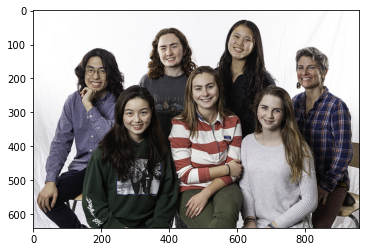

In [6]:
sample_img_path = 'Sample Images/example8.jpg'
show_img_from_path(sample_img_path)

In [7]:
if torch.cuda.is_available():
    print('cuda is available')
    
img = Image.open(sample_img_path)
sal_predicted = predict(SalGAN.eval(),img)

show_gray(sal_predicted)

print(sal_predicted.max(), sal_predicted.min())
sal_predicted = sal_predicted - sal_predicted.min()
sal_predicted = sal_predicted/sal_predicted.max()

pilImg = Image.open(sample_img_path)
s = np.array(pilImg)
s = transform.resize(s, (192, 256, 3))
s = np.array(s)

pilTrans = transforms.ToPILImage()
sal_predicted = pilTrans(sal_predicted)
sal_predicted = np.array(sal_predicted)
sal_predicted = transform.resize(sal_predicted, (192, 256, 3))

dst = cv2.addWeighted(sal_predicted, 1, s, 0, 0)
dst = np.array(dst * 255, dtype='uint8')

show_gray(dst)
print(sal_predicted.max(), sal_predicted.min())

cuda is available


RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

## code to process the entire ava dataset

In [ ]:
def SalGanAVA(csv_file, save_dir):
    
    csv = pd.read_csv(csv_file, sep=' ')
    
    for _, _, files in os.walk(image_dir): #get a list of file names in the dataset folder
        img_name_array = files
    
    for csv_idx, row in csv.iterrows(): #traverse the enitre csv file
        img_name = row[1]
        if (str(img_name) + '.jpg') in img_name_array:
            img = Image.open(os.path.join(image_dir, str(img_name) + '.jpg'))
            size = np.flip(np.array(img.size))
            img = np.array(img)
            
            try:
                sal_predicted = predict(SalGAN.eval(),img)
            except TypeError:
                print("Image reading: TypeError. Skipped")
            else:
                sal_predicted = sal_predicted - sal_predicted.min()
                sal_predicted = sal_predicted/sal_predicted.max()

                pilTrans = transforms.ToPILImage()
                sal_predicted = pilTrans(sal_predicted)
                sal_predicted = np.array(sal_predicted)
                sal_predicted = transform.resize(sal_predicted, size)

                sal_predicted = np.array(sal_predicted * 255, dtype='uint8')
            
                folder_path = os.path.join(save_dir,str(img_name))

                if not os.path.exists(folder_path):
                    os.mkdir(folder_path)
                else: print("Path exists: Overwriting...")


                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(folder_path, '0' + '.jpg'), img)
                cv2.imwrite(os.path.join(folder_path, '1' + '.jpg'), sal_predicted)
                if csv_idx % 10000 == 0:
                    print('==> csv_idx:', csv_idx)

In [ ]:
SalGanAVA(csv_file=csv_dir,save_dir = r"H:\AVA Featuremaps")